# Multiple Time Series, Pre-trained Models, and Covariates

Content from this notebook are referenced from https://unit8co.github.io/darts/examples/02-multi-time-series-and-covariates.html.

This notebook serves as a tutorial for:
- Training a single model on multiple time series
- Using a pre-trained model to obtain forecasts for any time series unseen during training
- Training and using a model using covariates

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

torch.manual_seed(1)
np.random.seed(1)

Importing plotly failed. Interactive plots will not work.


# Read Data

Let’s start by reading two time series - one containing the monthly number of air passengers, and another containing the monthly milk production per cow. These time series have not much to do with each other, except that they both have a monthly frequency with a marked yearly periodicity and upward trend, and (completely coincidentaly) they contain values of a comparable order of magnitude.



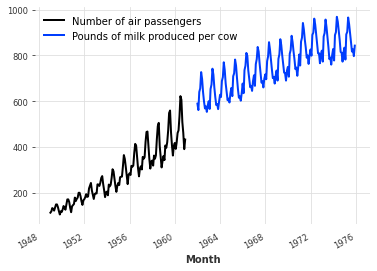

In [3]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label='Number of air passengers')
series_milk.plot(label='Pounds of milk produced per cow')
plt.legend()
plt.show()

# Preprocessing

Usually neural networks tend to work better on normalised/standardised data. Here we’ll use the `Scaler` class to normalise both of our time series between 0 and 1:

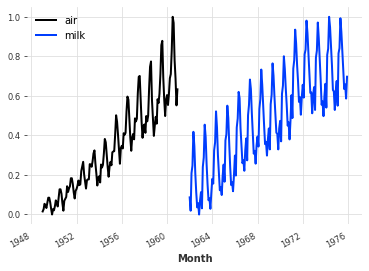

In [4]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label='air')
series_milk_scaled.plot(label='milk')
plt.legend()
plt.show()

# Train/Validation Split

Let's keep the last 36 months of both series as validation.

In [5]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

# Global Forecasting Models

Darts contains many forecasting models, but not all of them can be trained on several time series. The models that support training on multiple series are called global models. At the time of writing, there are 5 global models:
- BlockRNNModel
- RNNModel
- Temporal Convolutional Networks (TCNs)
- N-Beats
- Transformer model

In the following, we will distinguish two sorts of time series:
- The **target time series** is the time series we are interested to forecast (given its history)
- A **covariate time series** is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It’s sometimes also called external data.

We further differentiate covariates series, depending on whether they can be known in advance or not:
- **Past Covariates** denote time series whose past values are known at prediction time. These are usually things that have to be measured or observed.
- **Future Covariates** denote time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts.

Some models use only past covariates, others use only future covariates, and some models might use both. We will dive deeper in this topic in some other notebook, but for now it is enough to know this:
- `BlockRNNModel`, `TCNModel`, `NBEATSModel` and `TransformerModel` all use `past_covariates`.
- `RNNModel` uses `future_covariates`.

All of the global models listed above support training on multiple series. In addition, they also all support *multivariate series*. This means that they can seamlessly be used with time series of more than one dimension; the target series can contain one (as is often the case) or several dimensions. A time series with several dimensions is really just a regular time series where the values at each time stamps are vectors instead of scalars.

As an example, the 4 models supporting `past_covariates` follow a “block” architecture. They contain a neural network that takes chunks of time series in input, and outputs chunks of (predicted) future time series values. The input dimensionality is the number of dimensions (components) of the target series, plus the number of components of all the covariates - stacked together. The output dimensionality is simply the number of dimensions of the target series:

<img src="https://unit8co.github.io/darts/_images/seq_dataset_one_ts.png" width=750>

The `RNNModel` works differently, in a recurrent fashion (which is also why they support future covariates). The good news is that as a user, we don’t have to worry too much about the different model types and input/output dimensionalities. The dimensionalities are automatically inferred for us by the model based on the training data, and the support for past or future covariates is simply handled by the `past_covariates` or `future_covariates` arguments.

We’ll still have to specify two important parameters when building our models:
- `input_chunk_length`: this is the length of the lookback window of the model; so each output will be computed by the model by reading the previous `input_chunk_length` points.
- `output_chunk_length`: this is the length of the outputs (forecasts) produced by the internal model. However, the `predict()` method of the “outer” Darts model (e.g., the one of `NBEATSModel`, `TCNModel`, etc) can be called for a longer time horizon. In these cases, if `predict()` is called for a horizon longer than `output_chunk_length`, the internal model will simply be called repeatedly, feeding on its own previous outputs in an auto-regressive fashion. If `past_covariates` are used it requires these covariates to be known for long enough in advance.

# Example with One Series

Let’s look at a first example. We’ll build an N-BEATS model that has a lookback window of 24 points (`input_chunk_length=24`) and predicts the next 12 points (`output_chunk_length=12`). We chose these values so it’ll make our model produce successive predictions for one year at a time, looking at the past two years.

This model can be used like any other Darts forecasting model, beeing fit on a single time series:

In [7]:
model_air = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0)

model_air.fit(train_air, verbose=True)

[2022-01-07 14:41:34,688] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-01-07 14:41:34,688] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-01-07 14:41:34,763] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-07 14:41:34,763] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/200 [00:00<?, ?it/s]

And like any other Darts forecasting models, we can then get a forecast by calling `predict()`. Note that below, we are calling `predict()` with a horizon of 36, which is longer than the model internal `output_chunk_length` of 12. That’s not a problem here - as explained above, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

MAPE = 8.02%


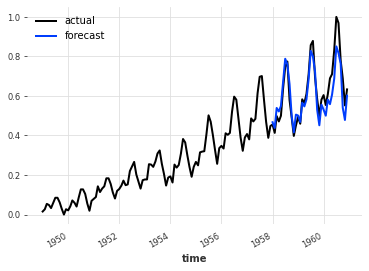

In [8]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend()
print(f"MAPE = {mape(series_air_scaled, pred):.2f}%")